In [1]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama
from langchain_huggingface import HuggingFaceEmbeddings  # HuggingFace嵌入

load_dotenv()

model = ChatOpenAI(
                    temperature=0,
                    max_tokens=4096,
                    presence_penalty=1.2,
                    # model='deepseek-chat',
                    # openai_api_key=os.getenv('DEEPSEEK_API_KEY'),
                    # openai_api_base="https://api.deepseek.com/v1",
                    model='gpt-4o-mini',
                    openai_api_key=os.getenv('CLOSEAI_API_KEY'),
                    openai_api_base="https://api.openai-proxy.org/v1",
                )

# model = ChatOllama(
#                     temperature=0,
#                     num_predict=4096,
#                     repeat_penalty=1.2,
#                     model="llama3.2:3b"
#                 )

# embedding = HuggingFaceEmbeddings(
#             model_name="../../Embedding/maidalun/bce-embedding-base_v1",
#             model_kwargs={"device": "cuda",
#                           "trust_remote_code": True},
#             encode_kwargs={"normalize_embeddings": True},
#         )

# Build the agent

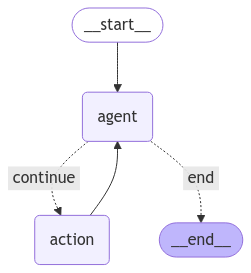

In [2]:
# Set up the tool
from langchain_core.tools import tool
from langgraph.graph import MessagesState, START
from langgraph.prebuilt import ToolNode
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver


@tool
def play_song_on_spotify(song: str):
    """Play a song on Spotify"""
    # Call the spotify API ...
    return f"Successfully played {song} on Spotify!"


@tool
def play_song_on_apple(song: str):
    """Play a song on Apple Music"""
    # Call the apple music API ...
    return f"Successfully played {song} on Apple Music!"


tools = [play_song_on_apple, play_song_on_spotify]
tool_node = ToolNode(tools)

# Set up the model

model = model.bind_tools(tools, parallel_tool_calls=False)


# Define nodes and conditional edges


# Define the function that determines whether to continue or not
def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"


# Define the function that calls the model
def call_model(state):
    messages = state["messages"]
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# Define a new graph
workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "action",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

# Set up memory
memory = MemorySaver()

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable

# We add in `interrupt_before=["action"]`
# This will add a breakpoint before the `action` node is called
app = workflow.compile(checkpointer=memory)

app

# Interacting with the Agent

In [3]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "1"}}
input_message = HumanMessage(content="Can you play Taylor Swift's most popular song?")
for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Can you play Taylor Swift's most popular song?
================================== Ai Message ==================================
Tool Calls:
  play_song_on_apple (call_mysHQyaOLZtMHzy5PBmUOLBJ)
 Call ID: call_mysHQyaOLZtMHzy5PBmUOLBJ
  Args:
    song: Anti-Hero by Taylor Swift
================================= Tool Message =================================
Name: play_song_on_apple

Successfully played Anti-Hero by Taylor Swift on Apple Music!
================================== Ai Message ==================================

I've started playing "Anti-Hero" by Taylor Swift on Apple Music! Enjoy the music!


# Checking history

In [4]:
app.get_state(config).values["messages"]

[HumanMessage(content="Can you play Taylor Swift's most popular song?", additional_kwargs={}, response_metadata={}, id='d97cb4e7-1fb4-4fdc-9402-92738a6a6912'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_mysHQyaOLZtMHzy5PBmUOLBJ', 'function': {'arguments': '{"song":"Anti-Hero by Taylor Swift"}', 'name': 'play_song_on_apple'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 80, 'total_tokens': 102, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_d02d531b47', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-834234ae-0442-4078-9162-599cf59b621c-0', tool_calls=[{'name': 'play_song_on_apple', 'args': {'song': 'Anti-Hero by Taylor Swift'}, 'id': 'call_mysHQyaOLZtMHzy5PB

In [5]:
all_states = []
for state in app.get_state_history(config):
    print(state)
    all_states.append(state)
    print("--")

StateSnapshot(values={'messages': [HumanMessage(content="Can you play Taylor Swift's most popular song?", additional_kwargs={}, response_metadata={}, id='d97cb4e7-1fb4-4fdc-9402-92738a6a6912'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_mysHQyaOLZtMHzy5PBmUOLBJ', 'function': {'arguments': '{"song":"Anti-Hero by Taylor Swift"}', 'name': 'play_song_on_apple'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 80, 'total_tokens': 102, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_d02d531b47', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-834234ae-0442-4078-9162-599cf59b621c-0', tool_calls=[{'name': 'play_song_on_apple', 'args': {'song': 'Anti-Hero by Taylor Swift'

# Replay a state

In [6]:
to_replay = all_states[2]

In [7]:
to_replay.values

{'messages': [HumanMessage(content="Can you play Taylor Swift's most popular song?", additional_kwargs={}, response_metadata={}, id='d97cb4e7-1fb4-4fdc-9402-92738a6a6912'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_mysHQyaOLZtMHzy5PBmUOLBJ', 'function': {'arguments': '{"song":"Anti-Hero by Taylor Swift"}', 'name': 'play_song_on_apple'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 80, 'total_tokens': 102, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_d02d531b47', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-834234ae-0442-4078-9162-599cf59b621c-0', tool_calls=[{'name': 'play_song_on_apple', 'args': {'song': 'Anti-Hero by Taylor Swift'}, 'id': 'call_mysH

In [8]:
to_replay.next

('action',)

In [9]:
for event in app.stream(None, to_replay.config):
    for v in event.values():
        print(v)

{'messages': [ToolMessage(content='Successfully played Anti-Hero by Taylor Swift on Apple Music!', name='play_song_on_apple', id='60cf640e-4e69-4368-ba60-6bf9c503536a', tool_call_id='call_mysHQyaOLZtMHzy5PBmUOLBJ')]}
{'messages': [AIMessage(content='I\'ve started playing "Anti-Hero" by Taylor Swift on Apple Music. Enjoy!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 125, 'total_tokens': 143, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0aa8d3e20b', 'finish_reason': 'stop', 'logprobs': None}, id='run-ed881224-75d7-4f62-8d53-74fd1949fe41-0', usage_metadata={'input_tokens': 125, 'output_tokens': 18, 'total_tokens': 143, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': 

# Branch off a past state

In [10]:
# Let's now get the last message in the state
# This is the one with the tool calls that we want to update
last_message = to_replay.values["messages"][-1]
last_message

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_mysHQyaOLZtMHzy5PBmUOLBJ', 'function': {'arguments': '{"song":"Anti-Hero by Taylor Swift"}', 'name': 'play_song_on_apple'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 80, 'total_tokens': 102, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_d02d531b47', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-834234ae-0442-4078-9162-599cf59b621c-0', tool_calls=[{'name': 'play_song_on_apple', 'args': {'song': 'Anti-Hero by Taylor Swift'}, 'id': 'call_mysHQyaOLZtMHzy5PBmUOLBJ', 'type': 'tool_call'}], usage_metadata={'input_tokens': 80, 'output_tokens': 22, 'total_tokens': 102, 'input_token_details': {'audio': 0, 'cache_read': 0

In [11]:
# Let's now update the tool we are calling
last_message.tool_calls[0]["name"] = "play_song_on_spotify"

branch_config = app.update_state(
    to_replay.config,
    {"messages": [last_message]},
)

In [12]:
for event in app.stream(None, branch_config):
    for v in event.values():
        print(v)

{'messages': [ToolMessage(content='Successfully played Anti-Hero by Taylor Swift on Spotify!', name='play_song_on_spotify', id='95f7123c-b871-4ad7-a9ee-ddb605b5f5f6', tool_call_id='call_mysHQyaOLZtMHzy5PBmUOLBJ')]}
{'messages': [AIMessage(content='I\'ve started playing "Anti-Hero" by Taylor Swift on Spotify. Enjoy the music!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 124, 'total_tokens': 144, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0aa8d3e20b', 'finish_reason': 'stop', 'logprobs': None}, id='run-0746aa57-4e89-4bb4-95cd-ab272422a996-0', usage_metadata={'input_tokens': 124, 'output_tokens': 20, 'total_tokens': 144, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_detail

In [13]:
from langchain_core.messages import AIMessage

# Let's now get the last message in the state
# This is the one with the tool calls that we want to update
last_message = to_replay.values["messages"][-1]

# Let's now get the ID for the last message, and create a new message with that ID.
new_message = AIMessage(
    content="It's quiet hours so I can't play any music right now!", id=last_message.id
)

branch_config = app.update_state(
    to_replay.config,
    {"messages": [new_message]},
)

In [14]:
branch_state = app.get_state(branch_config)

In [15]:
branch_state.values

{'messages': [HumanMessage(content="Can you play Taylor Swift's most popular song?", additional_kwargs={}, response_metadata={}, id='d97cb4e7-1fb4-4fdc-9402-92738a6a6912'),
  AIMessage(content="It's quiet hours so I can't play any music right now!", additional_kwargs={}, response_metadata={}, id='run-834234ae-0442-4078-9162-599cf59b621c-0')]}

In [16]:
branch_state.next

()